# Intro

To build the object detector for speed limit signs, I choose to train the Faster-RCNN model using Detectron2, which is Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms.

![img](https://github.com/facebookresearch/detectron2/raw/main/.github/Detectron2-Logo-Horz.svg)

# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# Data loading

In [ ]:
from collections import ChainMap
SPEED_THING_CLASSES = ['pl100', 'pl120', 'pl20', 'pl30', 'pl40', 'pl50', 'pl60', 'pl70', 'pl80']
SPEED_THING_DATASET_ID_TO_CONTIGUOUS_ID =  dict(
    ChainMap(*[{i: i} for i in range(9)]))

In [ ]:
import os

# Detectron imports
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
    
def setup_speed_dataset(dataset_dir):
    train_image_dir = os.path.join(dataset_dir, 'data')
    test_image_dir = os.path.join(dataset_dir, 'data')

    train_json_annotations = os.path.join(
        dataset_dir, 'train_dataset.json')
    test_json_annotations = os.path.join(
        dataset_dir, 'val_dataset.json')

    register_coco_instances(
        "speed_custom_train",
        {},
        train_json_annotations,  
        train_image_dir)
    MetadataCatalog.get(
        "speed_custom_train").thing_classes = SPEED_THING_CLASSES
    MetadataCatalog.get(
        "speed_custom_train").thing_dataset_id_to_contiguous_id = SPEED_THING_DATASET_ID_TO_CONTIGUOUS_ID

    register_coco_instances(
        "speed_custom_val",
        {},
        test_json_annotations,
        test_image_dir)
    MetadataCatalog.get(
        "speed_custom_val").thing_classes = SPEED_THING_CLASSES
    MetadataCatalog.get(
        "speed_custom_val").thing_dataset_id_to_contiguous_id = SPEED_THING_DATASET_ID_TO_CONTIGUOUS_ID

In [ ]:
setup_speed_dataset("dataset")

# Model definition & Training

The architecture that I choose is Faster R-CNN with ResNet-50 backbone, which is a classic object detection architecture combining the strength of Fast R-CNN in object classification and bounding box regression with the speed and accuracy of the Region Proposal Network (RPN). The RPN effectively generates high-quality region proposals that are potential objects, substantially reducing the number of candidate regions compared to previous methods. The incorporation of the ResNet backbone, known for its deep yet computationally efficient architecture characterized by residual learning, enhances the model's feature extraction capabilities.

I use a pretrained weight for Resnet backbone for initilization. It's trained on ImageNet and can be downloaded from the Detectron2 model zoo. I define the model using a config file in yaml:`model/configs/resnet.yaml`. The ResNet backbone's depth is 50 layers and the output layer size of classification head is defined as 9 for detecting 9 different speed limit signs presented in training data.
Regarding the trainig configuration, I use the default hyperparameters for solver from Detectron2 model zoo. Given that the model is trained on V100 GPU equipped with 32GB VRAM, I set a batch size of 24 to maximize the efficiency. The training is set to run for a total of 4200 iterations, which approximately corresponds to 20 epochs. In config file, I also set the evaluation period to perform model evaluation on the validation set every 10000 iterations.

![img](https://python5566.files.wordpress.com/2018/06/e89ea2e5b995e5bfabe785a7-2018-06-18-e4b88be58d885-12-56.png?w=720 "Faster-RCNN architecture")
*Source: [cs231n](http://cs231n.stanford.edu/slides/2020/lecture_12.pdf)*

In [1]:
import os
import sys


# Detectron imports
import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, verify_results


class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        """
        Builds evaluators for post-training mAP report.
        Args:
            cfg(CfgNode): a detectron2 CfgNode
            dataset_name(str): registered dataset name

        Returns:
            detectron2 DatasetEvaluators object
        """
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluators = [COCOEvaluator(dataset_name, cfg, True, output_folder)]
        return DatasetEvaluators(evaluators)

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        """
        Builds DataLoader for test set.
        Args:
            cfg(CfgNode): a detectron2 CfgNode
            dataset_name(str): registered dataset name

        Returns:
            detectron2 DataLoader object specific to the test set.
        """
        return build_detection_test_loader(
            cfg, dataset_name)

    @classmethod
    def build_train_loader(cls, cfg):
        """
        Builds DataLoader for train set.
        Args:
            cfg(CfgNode): a detectron2 CfgNode

        Returns:
            detectron2 DataLoader object specific to the train set.
        """
        return build_detection_train_loader(
            cfg)


In [1]:
#load cfg for detectron2 from the defined config yaml file
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file("model/configs/resnet.yaml")
cfg.OUTPUT_DIR = "model/output"
trainer = Trainer(cfg)
trainer.train()

Command Line Args: Namespace(config_file='model/configs/resnet.yaml', dataset_dir='export_dataset', dist_url='tcp://127.0.0.1:51118', eval_only=False, image_corruption_level=0, inference_config='', iou_correct=0.5, iou_min=0.1, machine_rank=0, min_allowed_score=0.0, num_gpus=1, num_machines=1, opts=[], random_seed=0, resume=False, savefigdir='./savefig', test_dataset='', visualize=0)
[12/15 22:23:32 detectron2]: Rank of current process: 0. World size: 1
[12/15 22:23:33 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
numpy                   1.21.6
detectron2              0.6 @/home/hew/.lo

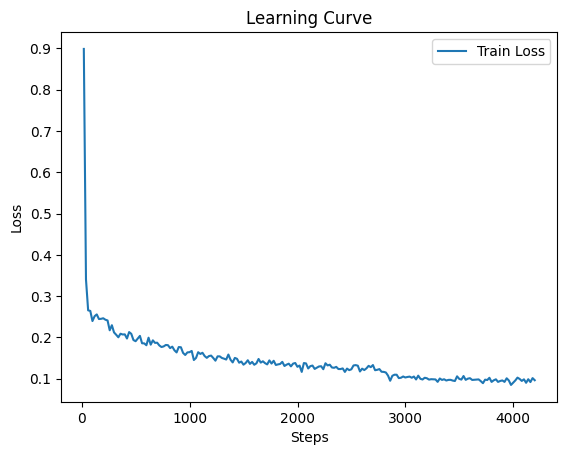

In [33]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# Path to the TensorBoard log directory
log_dir = "model/training_output"

# Load the TensorBoard event file
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# # Get the training loss values from the event file
train_loss = event_acc.Scalars('total_loss')

# # Extract the step and value for each loss
train_steps = [step.step for step in train_loss]
train_values = [step.value for step in train_loss]

# # Plot the learning curve
plt.plot(train_steps, train_values, label='Train Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


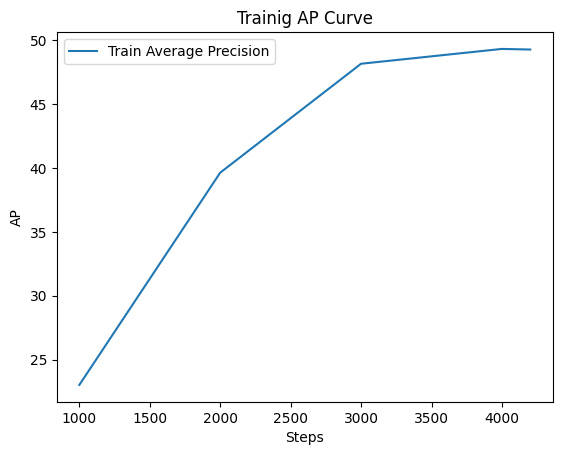

In [34]:
train_AP = event_acc.Scalars('bbox/AP')

# Extract the step and value for each loss
train_steps = [step.step for step in train_AP]
train_values = [step.value for step in train_AP]

# # Plot the learning curve
plt.plot(train_steps, train_values, label='Train Average Precision')
plt.xlabel('Steps')
plt.ylabel('AP')
plt.title('Trainig AP Curve')
plt.legend()
plt.show()

# Evaluation & Analysis

In [35]:
trainer.test(cfg, trainer.model)


WARNING [12/16 00:44:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/16 00:44:03 d2.data.datasets.coco]: Loaded 1028 images in COCO format from export_dataset/val_dataset.json
[12/16 00:44:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/16 00:44:04 d2.data.common]: Serializing 1028 elements to byte tensors and concatenating them all ...
[12/16 00:44:04 d2.data.common]: Serialized dataset takes 0.29 MiB
[12/16 00:44:04 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/16 00:44:04 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/16 00:44:04 d2.evaluation.evaluator]: Start inference on 1028 batches
[12/16 00:44:05 d2.evaluation.evaluator]:

Regarding Overall Average Precision, the AP of 49.25% is the average precision at different IoU thresholds (typically from 0.5 to 0.95 with a step size of 0.05). Notably, this performance metric aligns closely with the AP observed during training, as indicated by the training AP curve. This consistency between training and validation sets suggests that the model is not significantly overfitting. However, this performance might not be perfect, there is potential for further refinement to enhance its precision. In terms of AP50 and AP75, the values of 66% and 57%, respectively, highlight the model's robust performance at 50% and 75% IoU thresholds. 

When evaluating performance based on object sizes, the model exhibits a remarkable precision in detecting large objects. This suggests a potential area of focus for model improvement might be enhancing its ability to accurately identify smaller objects.

The Per-category AP varies significantly across categories (e.g., 67.376 for pl100 and 23.172 for pl20). Given that the pl100 has the most samples while pl20 has the least samples, this variation is probably due to the amount of the data. 

To address this imbalance and improve model performance on underrepresented categories like pl20, I believe implementing data augmentation strategies during retraining on this baseline model could be an effective approach. By enriching the dataset, especially for categories with fewer samples, the model may develop a more balanced and robust understanding of all categories, thereby improving its overall precision.


# Inference on unforeseen images

In [1]:
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file("model/configs/resnet.yaml")

In [4]:
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.detection_utils import read_image
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
# build a predictor on the trained model
cfg = get_cfg()
cfg.merge_from_file("model/configs/resnet.yaml")
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.WEIGHTS = "random_seed_0/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

def inference(image_path):
    # load image
    image = read_image(image_path, format="BGR")

    # Make inference on the image
    outputs = predictor(image)

    # Visualize the detection results
    MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).set(thing_classes=['pl100', 'pl120', 'pl20', 'pl30', 'pl40', 'pl50', 'pl60', 'pl70', 'pl80'])
    v = Visualizer(image, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display the visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

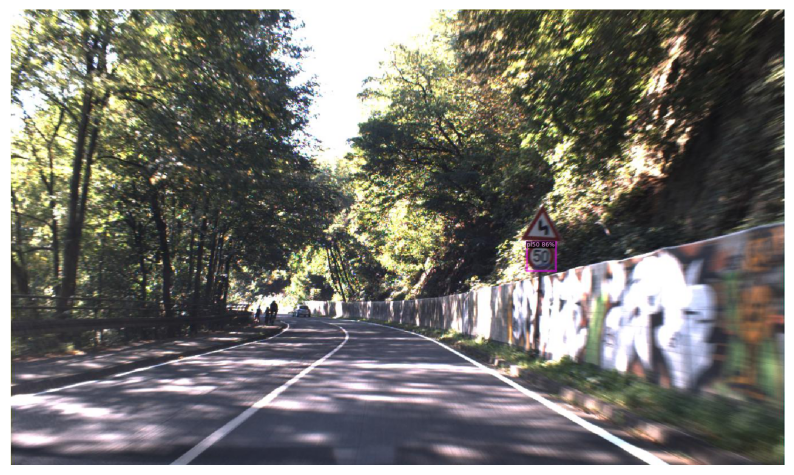

In [5]:
inference("img_test/1.jpg")

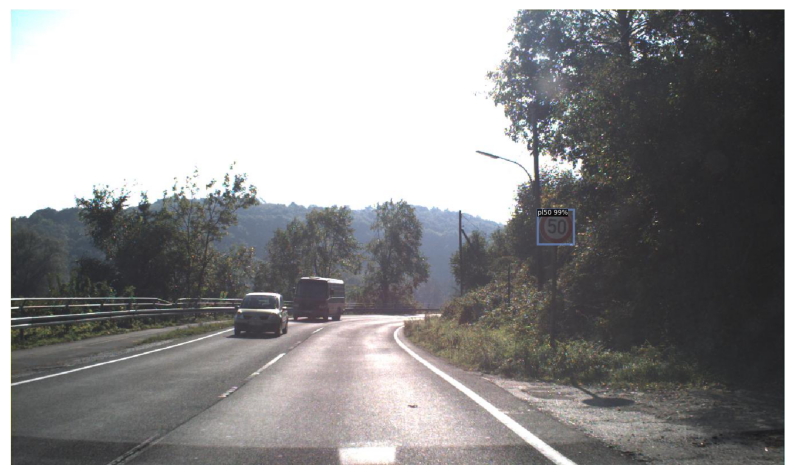

In [6]:
inference("img_test/2.jpg")

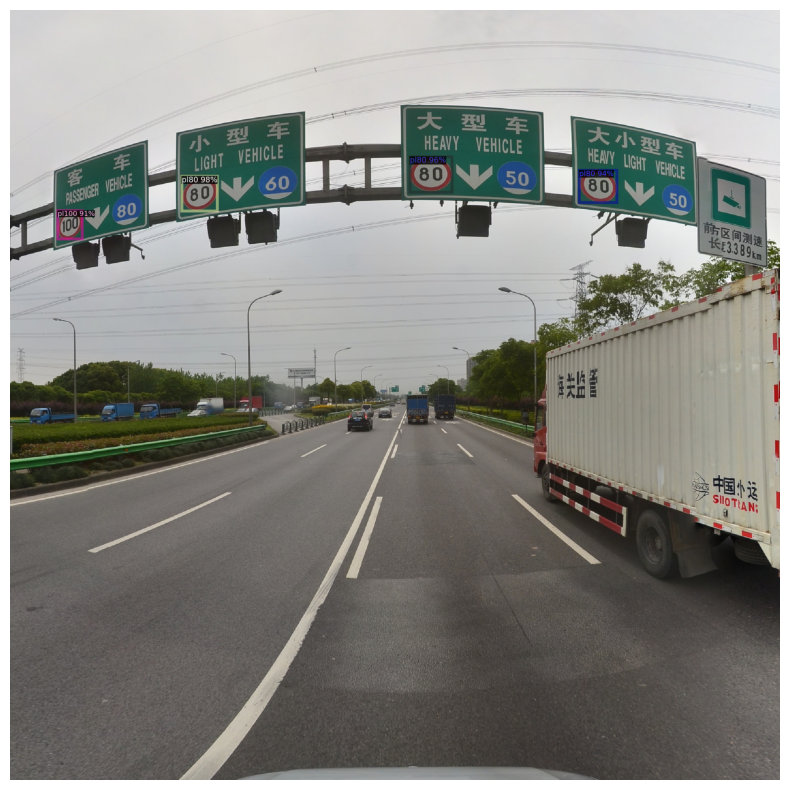

In [9]:
inference("img_test/3.jpg")

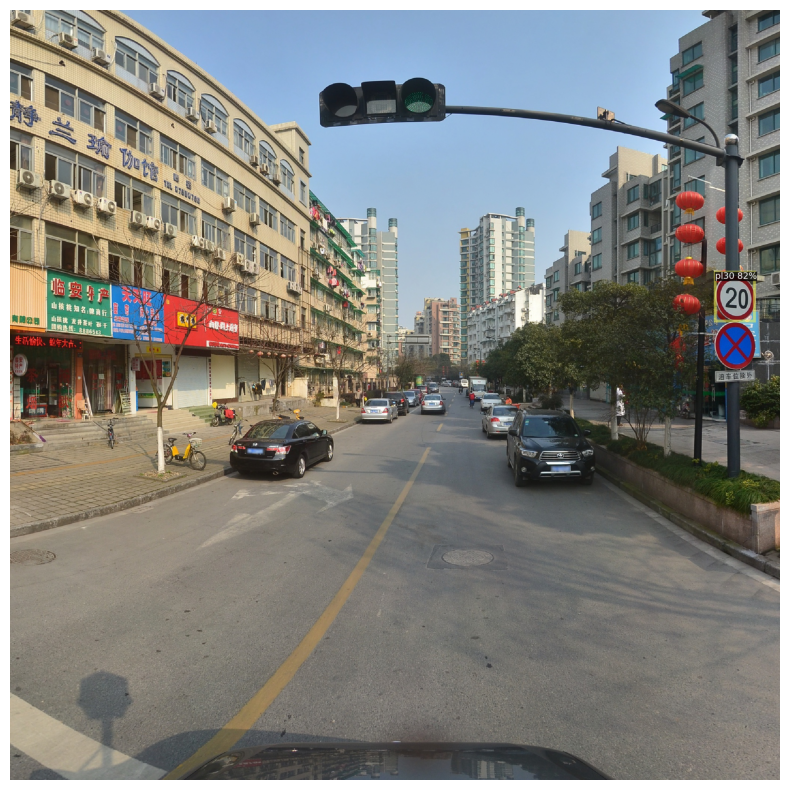

In [8]:
inference("img_test/4.jpg")

## Conclusion

Based on the observation of the inference results presented above, we can preliminarily conclude that the model exhibits strong performance in localizing and classifying the majority of speed limit signs, particularly demonstrating impressive accuracy in correctly identifying small speed limit signs. However, the analysis of the last image suggests that the model may encounter misclassification for certain less represented categories, such as “pl20”. More concerning is that this misclassification is associated with a high confidence score.

For the next step, to fix this issue, I believe retraining with data augmentation on these categories will be effective to achieve more balanced and robust performance of all categories, thereby improving its overall precision.